In [46]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Rutas de las carpetas que contienen las imágenes
covid_folder = 'dataset/images/COVID'
lung_opacity_folder = 'dataset/images/Lung_Opacity'
normal_folder = 'dataset/images/Normal'
viral_pneumonia_folder = 'dataset/images/Viral_Pneumonia'

# Función para guardar los datos en un archivo CSV
def guardar_csv(datos, nombre_archivo):
    with open(nombre_archivo, 'w', newline='') as archivo_csv:
        writer = csv.writer(archivo_csv)
        writer.writerows(datos)

# Cargar imágenes de pulmones con COVID
covid_data = []
for filename in os.listdir(covid_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(covid_folder, filename)
        etiqueta = 0  # Etiqueta 0 para COVID
        covid_data.append([img_path, etiqueta])

# Guardar los datos en el archivo CSV correspondiente
guardar_csv(covid_data, 'dataset/covid.csv')

# Cargar imágenes de pulmones con opacidad
lung_opacity_data = []
for filename in os.listdir(lung_opacity_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(lung_opacity_folder, filename)
        etiqueta = 1  # Etiqueta 1 para Opacidad pulmonar
        lung_opacity_data.append([img_path, etiqueta])

# Guardar los datos en el archivo CSV correspondiente
guardar_csv(lung_opacity_data, 'dataset/lung_opacity.csv')

# Cargar imágenes de pulmones sanos
normal_data = []
for filename in os.listdir(normal_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(normal_folder, filename)
        etiqueta = 2  # Etiqueta 2 para pulmones sanos
        normal_data.append([img_path, etiqueta])

# Guardar los datos en el archivo CSV correspondiente
guardar_csv(normal_data, 'dataset/normal.csv')

# Cargar imágenes de pulmones con neumonía viral
viral_pneumonia_data = []
for filename in os.listdir(viral_pneumonia_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(viral_pneumonia_folder, filename)
        etiqueta = 3  # Etiqueta 3 para Neumonía viral
        viral_pneumonia_data.append([img_path, etiqueta])

# Guardar los datos en el archivo CSV correspondiente
guardar_csv(viral_pneumonia_data, 'dataset/viral_pneumonia.csv')

Dimensiones de las imágenes: (299, 299)

Cantidad de imágenes por clase:

COVID:			 3616
Opacidad pulmonar:	 6012
Pulmones sanos:		 10192
Neumonía viral:		 1345


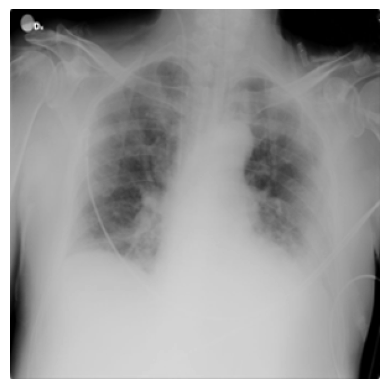

In [60]:
# Rutas de las carpetas que contienen las imágenes
covid_folder = 'dataset/images/COVID'
lung_opacity_folder = 'dataset/images/Lung_Opacity'
normal_folder = 'dataset/images/Normal'
viral_pneumonia_folder = 'dataset/images/Viral_Pneumonia'

img = cv2.imread('dataset/images/COVID/COVID-1.png', cv2.IMREAD_GRAYSCALE)
dimensiones = img.shape

# Cantidad de imágenes en cada clase
cantidad_covid = len(os.listdir(covid_folder))
cantidad_opacidad_pulmonar = len(os.listdir(lung_opacity_folder))
cantidad_pulmones_sanos = len(os.listdir(normal_folder))
cantidad_neumonia_viral = len(os.listdir(viral_pneumonia_folder))

print("Dimensiones de las imágenes:", dimensiones)
print("\nCantidad de imágenes por clase:\n")
print("COVID:\t\t\t", cantidad_covid)
print("Opacidad pulmonar:\t", cantidad_opacidad_pulmonar)
print("Pulmones sanos:\t\t", cantidad_pulmones_sanos)
print("Neumonía viral:\t\t", cantidad_neumonia_viral)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Feature engineering

### Se toma una cantidad especifica de cada conjunto para que haya una similitud entre todos los conjuntos y se redimenzionan a 128x128 

In [33]:
import os
import cv2
import numpy as np
import pandas as pd

# Rutas de los archivos CSV
covid_csv = 'dataset/covid.csv'
lung_opacity_csv = 'dataset/lung_opacity.csv'
normal_csv = 'dataset/normal.csv'
viral_pneumonia_csv = 'dataset/viral_pneumonia.csv'

# Directorios para guardar las imágenes redimensionadas
resized_covid_folder = 'dataset/resized_images/COVID'
resized_lung_opacity_folder = 'dataset/resized_images/Lung_Opacity'
resized_normal_folder = 'dataset/resized_images/Normal'
resized_viral_pneumonia_folder = 'dataset/resized_images/Viral_Pneumonia'

# Crear los directorios si no existen
os.makedirs(resized_covid_folder, exist_ok=True)
os.makedirs(resized_lung_opacity_folder, exist_ok=True)
os.makedirs(resized_normal_folder, exist_ok=True)
os.makedirs(resized_viral_pneumonia_folder, exist_ok=True)

# Función para redimensionar las imágenes y guardarlas en los nuevos directorios
def resize_and_save_images(image_folder, resized_folder, csv_file, num_samples):
    df = pd.read_csv(csv_file)  # Leer el archivo CSV
    df = df.head(num_samples)  # Seleccionar el número de muestras especificado
    for _, row in df.iterrows():
        img_path = row['image_path']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (128, 128))  # Redimensionar la imagen
        filename = os.path.basename(img_path)  # Obtener el nombre de archivo
        new_filename = os.path.splitext(filename)[0] + '_resized.png'  # Nuevo nombre de archivo
        cv2.imwrite(os.path.join(resized_folder, new_filename), resized_img)

# Redimensionar las imágenes de la clase COVID
resize_and_save_images(covid_folder, resized_covid_folder, covid_csv, 3616)

# Redimensionar las imágenes de la clase Opacidad pulmonar
resize_and_save_images(lung_opacity_folder, resized_lung_opacity_folder, lung_opacity_csv, 3700)

# Redimensionar las imágenes de la clase Pulmones sanos
resize_and_save_images(normal_folder, resized_normal_folder, normal_csv, 3700)

# Redimensionar las imágenes de la clase Neumonía viral
resize_and_save_images(viral_pneumonia_folder, resized_viral_pneumonia_folder, viral_pneumonia_csv, 1345)

print("Imágenes redimensionadas guardadas en los nuevos directorios.")


Imágenes redimensionadas guardadas en los nuevos directorios.


Dimensiones de las imágenes: (128, 128)

Cantidad de imágenes por clase:

COVID:			 3616
Opacidad pulmonar:	 3700
Pulmones sanos:		 3700
Neumonía viral:		 1345


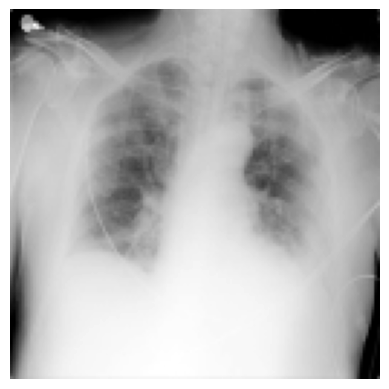

In [57]:
# Rutas de las carpetas que contienen las imágenes
resized_images_covid_folder = 'dataset/resized_images/COVID'
resized_images_lung_opacity_folder = 'dataset/resized_images/Lung_Opacity'
resized_images_normal_folder = 'dataset/resized_images/Normal'
resized_images_viral_pneumonia_folder = 'dataset/resized_images/Viral_Pneumonia'

img = cv2.imread('dataset/resized_images/COVID/COVID-1_resized.png', cv2.IMREAD_GRAYSCALE)
dimensiones = img.shape
    
# Cantidad de imágenes en cada clase
resized_images_cantidad_covid = len(os.listdir(resized_images_covid_folder))
resized_images_cantidad_opacidad_pulmonar = len(os.listdir(resized_images_lung_opacity_folder))
resized_images_cantidad_pulmones_sanos = len(os.listdir(resized_images_normal_folder))
resized_images_cantidad_neumonia_viral = len(os.listdir(resized_images_viral_pneumonia_folder))

print("Dimensiones de las imágenes:", dimensiones)
print("\nCantidad de imágenes por clase:\n")
print("COVID:\t\t\t", resized_images_cantidad_covid)
print("Opacidad pulmonar:\t", resized_images_cantidad_opacidad_pulmonar)
print("Pulmones sanos:\t\t", resized_images_cantidad_pulmones_sanos)
print("Neumonía viral:\t\t", resized_images_cantidad_neumonia_viral)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

### Se estandarizan las imagenes despues del redimencionamiento

In [44]:
import os
import cv2
import numpy as np

# Directorios para guardar las imágenes redimensionadas
estandarized_covid_folder = 'dataset/estandarized_images/COVID'
estandarized_lung_opacity_folder = 'dataset/estandarized_images/Lung_Opacity'
estandarized_normal_folder = 'dataset/estandarized_images/Normal'
estandarized_viral_pneumonia_folder = 'dataset/estandarized_images/Viral_Pneumonia'

# Crear los directorios si no existen
os.makedirs(estandarized_covid_folder, exist_ok=True)
os.makedirs(estandarized_lung_opacity_folder, exist_ok=True)
os.makedirs(estandarized_normal_folder, exist_ok=True)
os.makedirs(estandarized_viral_pneumonia_folder, exist_ok=True)


# Función para estandarizar y guardar las imágenes en nuevos directorios
def estandarizar_y_guardar_imagenes(resized_folder, estandarized_folder):
    for filename in os.listdir(resized_folder):
        if filename.endswith('.png'):
            imagen_ruta = os.path.join(resized_folder, filename)  # Ruta de la imagen actual
            imagen = cv2.imread(imagen_ruta, cv2.IMREAD_GRAYSCALE)  # Cargar la imagen en escala de grises

            imagen_flotante = imagen.astype("float32")  # Convertir la imagen en un array NumPy de punto flotante

            media, desviacion = cv2.meanStdDev(imagen_flotante)  # Calcular media y desviación estándar

            media_estandarizada = 127
            desviacion_estandarizada = 63

            imagen_estandarizada = (imagen_flotante - media) / desviacion * desviacion_estandarizada + media_estandarizada

            imagen_estandarizada_enteros = imagen_estandarizada.astype("uint8")  # Convertir imagen a enteros

            new_filename = os.path.splitext(filename)[0] + '_standarized.png'  # Nuevo nombre de archivo
            cv2.imwrite(os.path.join(estandarized_folder, new_filename), imagen_estandarizada_enteros)  # Guardar la imagen estandarizada


# Estandarizar y guardar las imágenes del conjunto COVID
estandarizar_y_guardar_imagenes('dataset/resized_images/COVID', estandarized_covid_folder)

# Estandarizar y guardar las imágenes del conjunto Opacidad pulmonar
estandarizar_y_guardar_imagenes('dataset/resized_images/Lung_Opacity', estandarized_lung_opacity_folder)

# Estandarizar y guardar las imágenes del conjunto Pulmones sanos
estandarizar_y_guardar_imagenes('dataset/resized_images/Normal', estandarized_normal_folder)

# Estandarizar y guardar las imágenes del conjunto Neumonía viral
estandarizar_y_guardar_imagenes('dataset/resized_images/Viral_Pneumonia', estandarized_viral_pneumonia_folder)

print("Imágenes estandarizadas guardadas en los nuevos directorios.")


Imágenes estandarizadas guardadas en los nuevos directorios.


Dimensiones de las imágenes: (128, 128)

Cantidad de imágenes por clase:

COVID:			 3616
Opacidad pulmonar:	 3700
Pulmones sanos:		 3700
Neumonía viral:		 1345


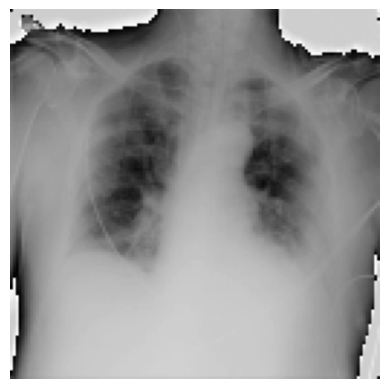

In [59]:
# Rutas de las carpetas que contienen las imágenes
standarized_images_covid_folder = 'dataset/estandarized_images/COVID'
standarized_images_lung_opacity_folder = 'dataset/estandarized_images/Lung_Opacity'
standarized_images_normal_folder = 'dataset/estandarized_images/Normal'
standarized_images_viral_pneumonia_folder = 'dataset/estandarized_images/Viral_Pneumonia'

img = cv2.imread('dataset/estandarized_images/COVID/COVID-1_resized_standarized.png', cv2.IMREAD_GRAYSCALE)
dimensiones = img.shape
    
# Cantidad de imágenes en cada clase
standarized_images_cantidad_covid = len(os.listdir(standarized_images_covid_folder))
standarized_images_cantidad_opacidad_pulmonar = len(os.listdir(standarized_images_lung_opacity_folder))
standarized_images_cantidad_pulmones_sanos = len(os.listdir(standarized_images_normal_folder))
standarized_images_cantidad_neumonia_viral = len(os.listdir(standarized_images_viral_pneumonia_folder))

print("Dimensiones de las imágenes:", dimensiones)
print("\nCantidad de imágenes por clase:\n")
print("COVID:\t\t\t", standarized_images_cantidad_covid)
print("Opacidad pulmonar:\t", standarized_images_cantidad_opacidad_pulmonar)
print("Pulmones sanos:\t\t", standarized_images_cantidad_pulmones_sanos)
print("Neumonía viral:\t\t", standarized_images_cantidad_neumonia_viral)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()